# Planning in Python

Here we illustrate how to use our library to pose a simple Hanoi puzzle and solve it with our planning framework. We have implemented both blind search algorithms and informed (heuristic) search. This notebook gives a flavour of these techniques.

## Simple example with 4 pegs

We start importing the relevant modules:

In [1]:
import planning

from IPython.display import display

Now let us pose a simple problem with 4 pegs and 5 disks. The domain is already defined and it contains a single operator: `move(?what-disk, ?from-object, ?to-object)`, which moves disk `?what` from object `?from` (either a peg or another disk) to object `?to` (also, either a peg or a disk). Our planning framework can take care of static preconditions. That is, it does not instantiate the move operator for moving a disk onto a smaller disk) so it is not necessary to encode static predicates in the state (the `smaller(?disk1,?disk2)` predicates that are typically seen in PDDL Hanoi domains).

We have also implemented a problem generator. The generator can create problems for any number of disks and pegs. It also allows random initial and ending configurations. Our first example will be fairly simple and will have 3 pegs, all the disks in the first peg in the initial state and all the disks in the third peg in the goal configuration. Although the goal in this case details the position of every disk, notice that this does not necessarily has to be the case always. The goal does not need to be a complete description of the end configuration. It is perfectly reasonable, and our framework allows it, to consider partial states (e.g. we want the biggest disk in the third peg, and we do not care about the rest).

Domain: Hanoi
Types: {'peg': 'object', 'disk': 'object'}
Operators:
  - move(?what-disk,?from-object,?to-object):
    Pre: clear(?what), clear(?to), on(?what,?from), smaller(?what,?to)
    Add: clear(?from), on(?what,?to)
    Delete: clear(?to), on(?what,?from)
Init:


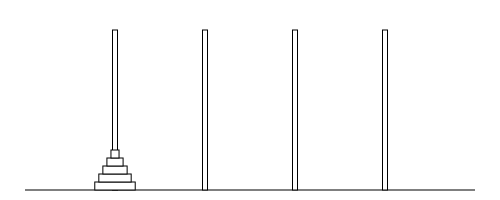

Goal:


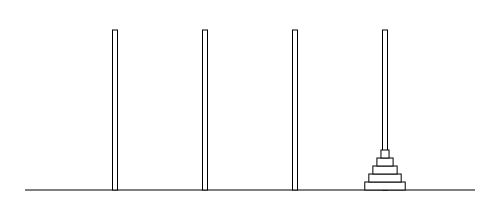

Applicable actions in 1st state:
move(disk01,disk02,peg2)
move(disk01,disk02,peg3)
move(disk01,disk02,peg4)


In [2]:
domain = planning.domains["Hanoi"]
problem = domain.generate_problem(5, 4, random=False)
print(domain)
# print(problem)
print("Init:")
display(problem.init())
print("Goal:")
display(problem.goal())
print("Applicable actions in 1st state:")
l = list(filter(problem.init().can_apply, problem.operators()))
print("\n".join(map(str, l)))
# print(planning.pddl_utility.pddl_actions(l))
# print(planning.pddl_utility.pddl_domain(domain))
# print(planning.pddl_utility.pddl_problem(problem))

# with open("domain.pddl", "w") as d, open("problem.pddl","w") as p:
#     d.write(planning.pddl_utility.pddl_domain(domain, problem.operators()))
#     p.write(planning.pddl_utility.pddl_problem(problem))


Let us start applying blind search algorithms. Namely, we have implemented Breadth First Search (BFS) and Iterative Deepening Search (IDS). The algorithms have an exponential worst time complexity. More specifically, both have a time complexity of $ O(b^d) $ where $ b $ is the branching factor and $ d $ is the length of the plan. Moreover, BFS is very memory intensive, requiring also an exponential amount of memory. IDS sacrifices speed for memory efficiency: it has a linear memory usage, but requires more time than BFS to find a plan, namely, a constant factor times the time required by BFS which, of course, is hidden in the big O notation.

Let us start with BFS:

[1.051s] Plan found with 13 action(s)
#Generated nodes: 1020
Plan:
  move(disk01,disk02,peg2)
  move(disk02,disk03,peg3)
  move(disk01,peg2,disk02)
  move(disk03,disk04,peg4)
  move(disk04,disk05,peg2)
  move(disk03,peg4,disk04)
  move(disk05,peg1,peg4)
  move(disk03,disk04,peg1)
  move(disk04,peg2,disk05)
  move(disk01,disk02,peg2)
  move(disk03,peg1,disk04)
  move(disk02,peg3,disk03)
  move(disk01,peg2,disk02)
step 0


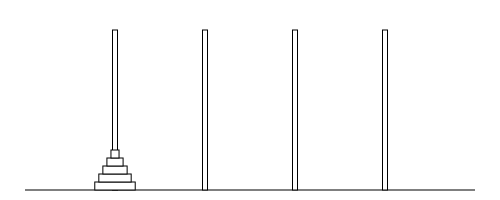

step 1


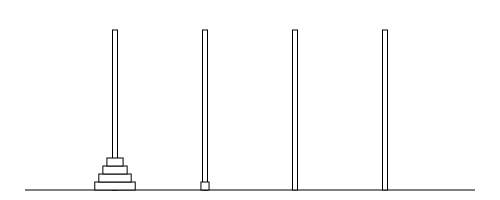

step 2


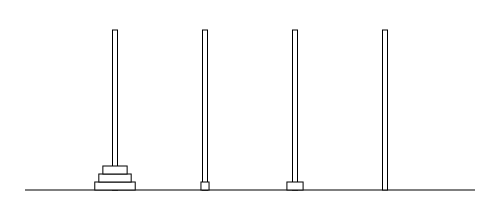

step 3


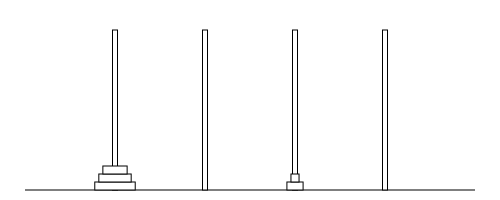

step 4


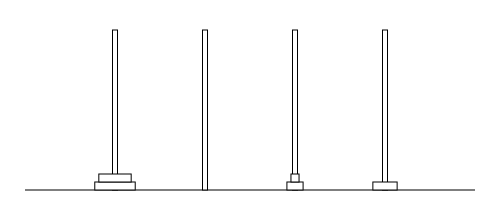

step 5


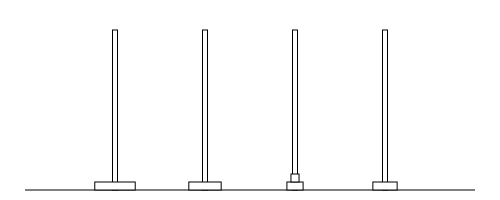

step 6


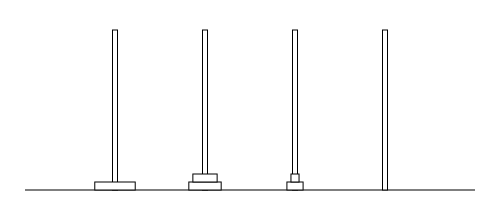

step 7


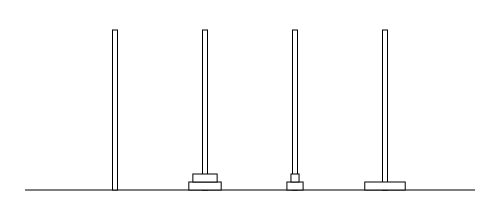

step 8


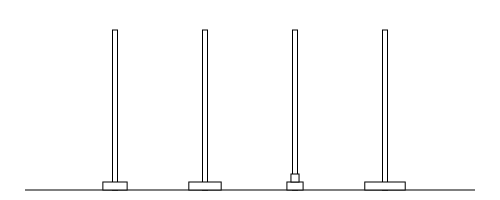

step 9


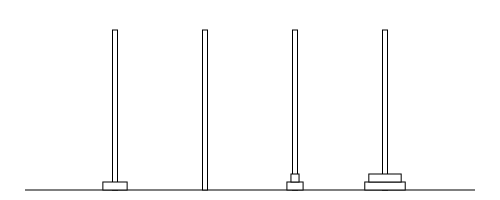

step 10


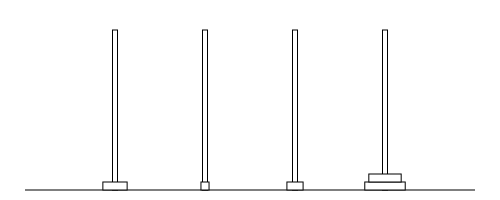

step 11


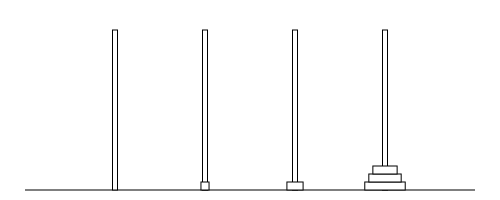

step 12


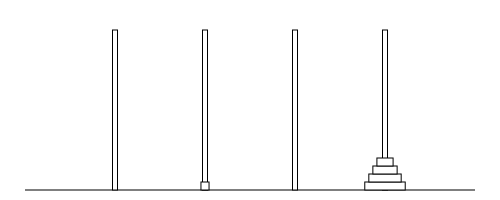

step 13


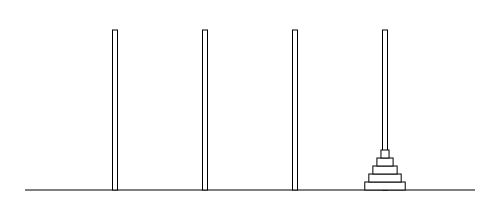

In [3]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if len(plan) < 15:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

Let us apply IDS now:

In [16]:
ids = planning.IterativeDeepeningSearch(problem, verbose=1, timeout=30.0)
status = ids()
if status == planning.search.FOUND:
    plan = ids.plan()
    state_sequence = ids.state_sequence()
    if len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in ids.plan()]))
        for i, state in enumerate(ids.state_sequence()):
            print("step " + str(i))
            display(state)

[0.001s] Trying depth 1...
[0.001s] Trying depth 2...
[0.002s] Trying depth 3...
[0.005s] Trying depth 4...
[0.019s] Trying depth 5...
[0.067s] Trying depth 6...
[0.256s] Trying depth 7...
[1.046s] Trying depth 8...
[4.379s] Trying depth 9...
[18.942s] Trying depth 10...
[30.004s] Timeout
[30.004s] Could not find solution


Now, let us apply heuristic search. We have implemented a generic Best First Search algorithm that accepts any heuristic and uses it to guide the search. We have implemented the following heuristics:
- Goal counting heuristic
- Relaxed goal counting heuristic
- Novelty-based heuristics
- Additive heuristic ($ h_{add} $)
- Relaxed planning graph heuristic (equivalent to $ h_{max} $)

We can combine these heuristics to achieve certain behaviour. For instance, we can use a linear combination of the accumulated cost and the novelty or additive heuristic to get the $\epsilon-A*$ (epsilon A-star) behaviour. The improvement with respect to the blind search is evident:

In [9]:
g = planning.heuristics.AccumulatedCost()
hadd = planning.heuristics.AdditiveHeuristic()
rpg = planning.heuristics.RelaxedPlanningGraphHeuristic()
hlinear = planning.heuristics.LinearCombination([g, hadd], (1, 5)) # 5 A-star with additive heuristic
h = planning.heuristics.ConcatenateHeuristic([hlinear, hadd])

bfs = planning.BestFirstSearch(problem, verbose=1, timeout=300.0, node_bound=20000,
                               heuristic=h, close_forever=False)
bfs()
plan = bfs.plan()
state_sequence = bfs.state_sequence()
print("#Generated nodes: " + str(bfs.info()["generated"]))
if len(plan) < 10:
    print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
    for i, state in enumerate(bfs.state_sequence()):
        print("step " + str(i))
        display(state)

[0.090s] Plan found with 13 action(s)
#Generated nodes: 82


Now let us generate a bunch of problems and store their heuristic values. We will also store the optimum plan length for all these states.

In [34]:
import random
import tqdm
import numpy as np
import os

random.seed(42)

m = 4 # 4-peg Hanoi towers

load = False

datadir = os.path.join("data", "hanoi", str(m))

try:
    os.makedirs(datadir)
except OSError:
    pass

X_file = os.path.join(datadir, "X.npy")
y_file = os.path.join(datadir, "y.npy")

if load:
    X = np.load(X_file)
    y = np.load(y_file)
else:

    X = []
    y = []

    N = 100

    generated = set()
    
    # Available heuristics:
    # "add()", "ff()", "cg()", "lmcut()", "cegar()", 
    # "hmax()", "cpdbs()", "cea()", "zopdbs()", "goalcount()"
#     fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()",
#                                          "hmax()", "cpdbs()", "goalcount()")
    fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()")

    for _ in tqdm.tqdm_notebook(range(N)):
        while True:
            n = random.randint(3, 5)
    #         m = random.randint(3, 4)
            problem = domain.generate_problem(n, m, random=True)
            if not problem.trivial() and (problem.init(), problem.goal()) not in generated:
                break
        bfs = planning.BreadthFirstSearch(problem, verbose=0, timeout=300.0, node_bound=None)
        status = bfs()
        if status == planning.search.FOUND:
            plan_len = len(bfs.plan())
            for i, state in enumerate(bfs.state_sequence()):
                generated.add((state, problem.goal()))
                X.append(fd.h(state, problem.goal()))
                y.append(plan_len - i)

    X = np.array(X)
    y = np.array(y)
    
    np.save(X_file, X)
    np.save(y_file, y)
    

#Instances: 584


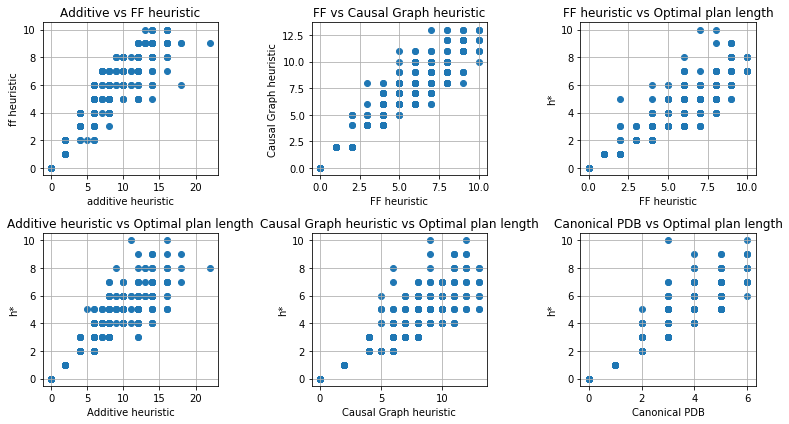

In [35]:
import matplotlib as mlp
%matplotlib inline
plt = mlp.pyplot
plt.rcParams["figure.figsize"] = [11, 6]
mlp.rcParams["figure.dpi"] = 72

print("#Instances: " + str(X.shape[0]))

plt.subplot(2, 3, 1)
plt.scatter(X[:,0], X[:,1])
plt.grid("on")
plt.xlabel("additive heuristic")
plt.ylabel("ff heuristic")
plt.title("Additive vs FF heuristic")

plt.subplot(2, 3, 2)
plt.scatter(X[:,1], X[:,2])
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("Causal Graph heuristic")
plt.title("FF vs Causal Graph heuristic")

plt.subplot(2, 3, 3)
plt.scatter(X[:,1], y)
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("h*")
plt.title("FF heuristic vs Optimal plan length")

plt.subplot(2, 3, 4)
plt.scatter(X[:,0], y)
plt.grid("on")
plt.xlabel("Additive heuristic")
plt.ylabel("h*")
plt.title("Additive heuristic vs Optimal plan length")

plt.subplot(2, 3, 5)
plt.scatter(X[:,2], y)
plt.grid("on")
plt.xlabel("Causal Graph heuristic")
plt.ylabel("h*")
plt.title("Causal Graph heuristic vs Optimal plan length")

plt.subplot(2, 3, 6)
plt.scatter(X[:,-2], y)
plt.grid("on")
plt.xlabel("Canonical PDB")
plt.ylabel("h*")
plt.title("Canonical PDB vs Optimal plan length")

plt.tight_layout()
plt.show()

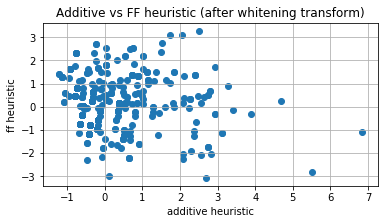

In [36]:
from scipy.linalg import sqrtm

X_ = X - np.mean(X, 0)

V = np.matrix(np.cov(X_.T))
VI = np.linalg.inv(V)

VI_sqrt = sqrtm(VI)

X_ = np.matmul(X_, VI_sqrt)

plt.figure(figsize=(6,3))
plt.scatter(X_[:,0], X_[:,1])
plt.grid("on")
plt.xlabel("additive heuristic")
plt.ylabel("ff heuristic")
plt.title("Additive vs FF heuristic (after whitening transform)")
plt.show()

In [37]:
from scipy.linalg import sqrtm

from sklearn import neighbors
from sklearn.model_selection import cross_val_score


dist = neighbors.DistanceMetric.get_metric("mahalanobis", VI=VI)

psplit = 0.8

n = X.shape[0]
n_train = int(n*psplit)
n_test = n - n_train

# weights = [1,1,1,1,1,1,1,1]

X_train = X[:n_train,:]
y_train = y[:n_train]

# V = np.matrix(np.cov(X_train.T))
# VI_sqrt = sqrtm(V.I)

# X_train = np.matmul(X_train, VI_sqrt)*weights

X_test = X[n_train:,:]
# X_test = np.matmul(X[n_train:, columns], VI_sqrt)*weights
y_test = y[n_train:]

knn = neighbors.KNeighborsRegressor(4, weights="distance")

knn.fit(X_train, y_train)

y_ = knn.predict(X_test)

# print(y_test[10:20])
# print(y_[10:20])
# print(X_test[10:20,:])

error = np.sqrt(np.sum((y_ - y_test)**2)/n_test)

print("RMS error: {:.02}".format(error))

ranking_errors = 0
ranking_errors_simple = 0

for i in range(n_test):
    for j in range(n_test):
        y1, y1_ = y_test[i], y_[i]
        y2, y2_ = y_test[j], y_[j]
        x1, x2 = X_test[i,0], X_test[j,0]
        if y1 < y2 and y1_ >= y2_:
            ranking_errors += 1
        elif y1 > y2 and y1_ <= y2_:
            ranking_errors += 1
        if y1 < y2 and x1 >= x2:
            ranking_errors_simple += 1
        elif y1 > y2 and x1 <= x2:
            ranking_errors_simple += 1
            
print("Ranking error (KNN): {:.02f}%".format(100*ranking_errors/(n_test*n_test)))
print("Ranking error (hadd): {:.02f}%".format(100*ranking_errors_simple/(n_test*n_test)))

# print(cross_val_score(knn, X_, y, cv=10, scoring="r2"))

RMS error: 0.52
Ranking error (KNN): 2.28%
Ranking error (hadd): 4.65%


[0.817s] Plan found with 9 action(s)
#Generated nodes: 134
Plan:
  move(disk01,disk02,peg2)
  move(disk02,disk03,peg3)
  move(disk01,peg2,disk02)
  move(disk03,disk04,peg2)
  move(disk04,peg1,peg4)
  move(disk03,peg2,disk04)
  move(disk01,disk02,peg1)
  move(disk02,peg3,disk03)
  move(disk01,peg1,disk02)
step 0


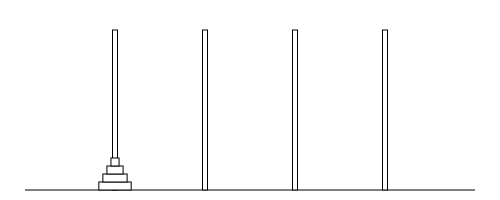

step 1


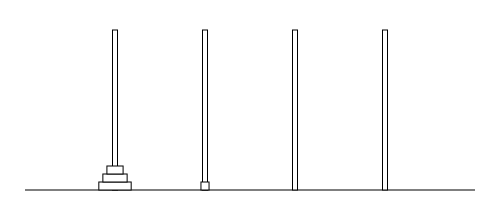

step 2


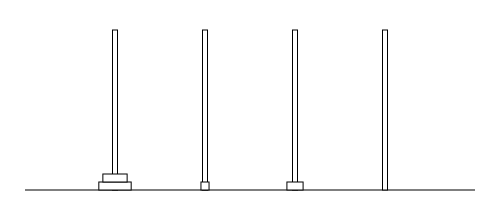

step 3


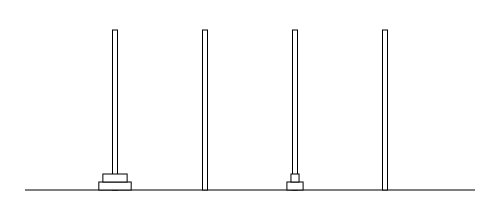

step 4


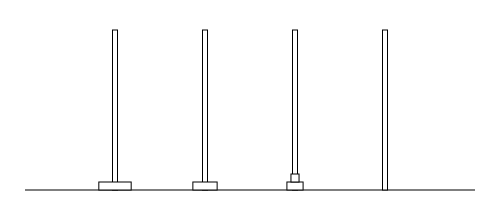

step 5


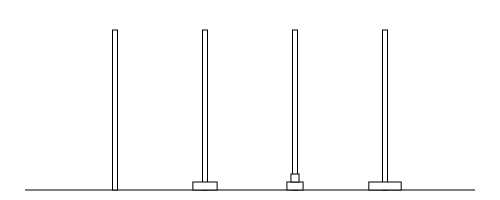

step 6


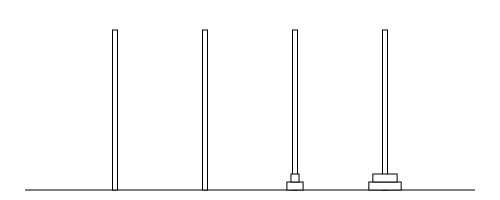

step 7


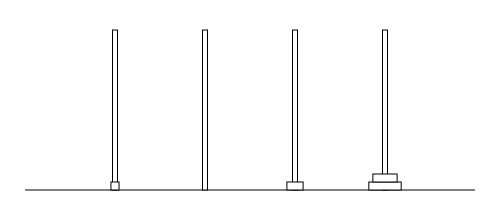

step 8


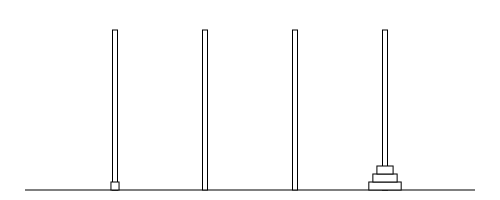

step 9


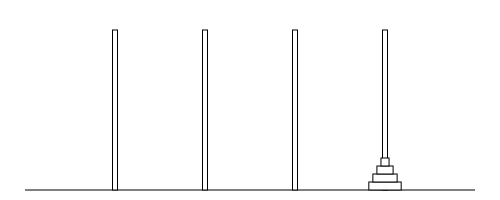

In [32]:
random.seed(42)

problem = domain.generate_problem(4, 4, random=False)

g = planning.heuristics.AccumulatedCost()
fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()",
                                     "hmax()", "cpdbs()", "goalcount()")
cbr = planning.heuristics.CBRHeuristic(fd, X, y, k=4, weights="distance")
hlinear = planning.heuristics.LinearCombination([g, cbr], (1, 1)) # 5 A-star with additive heuristic
h = planning.heuristics.ConcatenateHeuristic([hlinear, cbr])

bfs = planning.BestFirstSearch(problem, verbose=1, timeout=300.0, node_bound=20000,
                               heuristic=h, close_forever=True)
bfs()
plan = bfs.plan()
state_sequence = bfs.state_sequence()
print("#Generated nodes: " + str(bfs.info()["generated"]))
if len(plan) < 10:
    print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
    for i, state in enumerate(bfs.state_sequence()):
        print("step " + str(i))
        display(state)

[0.034s] Plan found with 9 action(s)
#Generated nodes: 43
Plan:
  move(disk01,disk02,peg2)
  move(disk02,disk03,peg3)
  move(disk01,peg2,disk02)
  move(disk03,disk04,peg2)
  move(disk04,peg1,peg4)
  move(disk03,peg2,disk04)
  move(disk01,disk02,peg1)
  move(disk02,peg3,disk03)
  move(disk01,peg1,disk02)
step 0


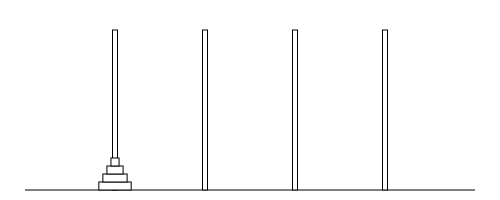

step 1


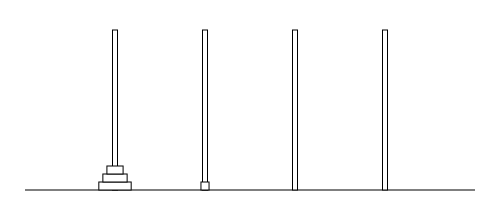

step 2


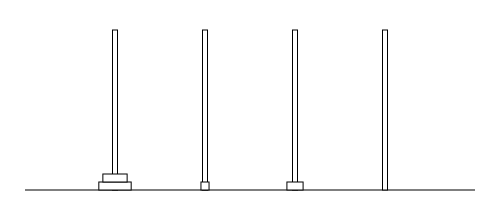

step 3


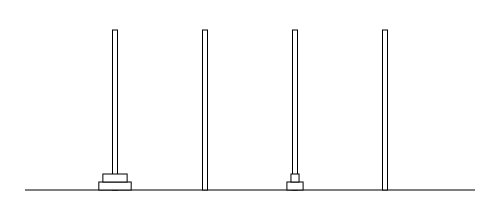

step 4


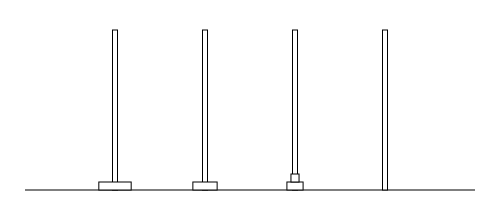

step 5


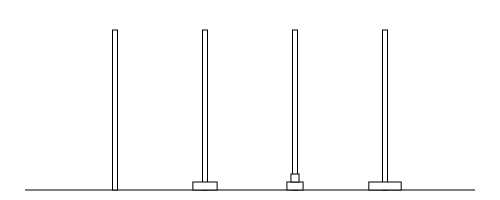

step 6


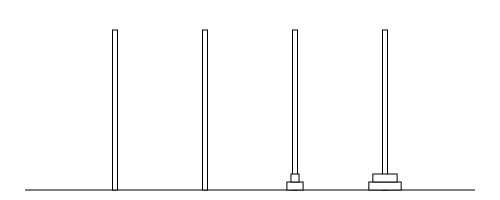

step 7


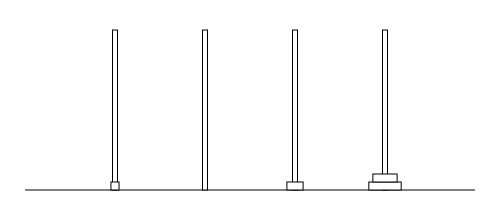

step 8


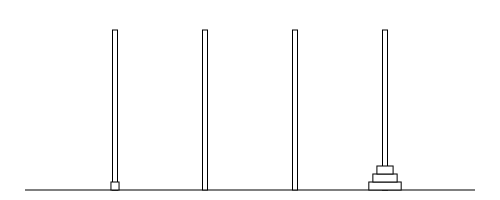

step 9


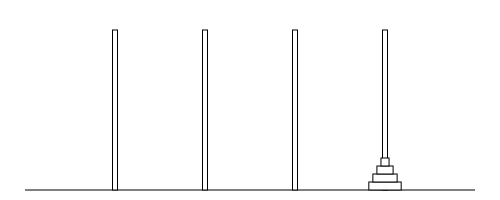

In [33]:
random.seed(42)

problem = domain.generate_problem(4, 4, random=False)

g = planning.heuristics.AccumulatedCost()
fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()",
                                     "hmax()", "cpdbs()", "goalcount()")
cbr = planning.heuristics.CBRHeuristic(fd, X, y, k=4, weights="distance")
hlinear = planning.heuristics.LinearCombination([g, hadd], (1, 1)) # 5 A-star with additive heuristic
h = planning.heuristics.ConcatenateHeuristic([hlinear, hadd])

bfs = planning.BestFirstSearch(problem, verbose=1, timeout=300.0, node_bound=20000,
                               heuristic=h, close_forever=False)
bfs()
plan = bfs.plan()
state_sequence = bfs.state_sequence()
print("#Generated nodes: " + str(bfs.info()["generated"]))
if len(plan) < 10:
    print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
    for i, state in enumerate(bfs.state_sequence()):
        print("step " + str(i))
        display(state)